## 1.中值滤波

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def medianBlur(img, kernel, padding_way='ZERO', Multithreading=False):
    # 检测传入的kernel是否为一个合法数组.
    if kernel % 2 == 0 or kernel is 1:
        print('kernel size need 3, 5, 7, 9....')
        return None

    # 通过kernel的大小来计算paddingSize的大小
    paddingSize = kernel // 2

    # 获取图片的通道数
    layerSize = len(img.shape)

    # 获取传入的图片的大小
    height, width = img.shape[:2]

    # 假设输入,如下矩阵,5x5
    # [[2 6 3 4 7]
    #  [6 1 7 1 5]
    #  [4 6 7 3 3]
    #  [3 1 8 8 6]
    #  [2 4 8 0 7]]

    # 这里是对多通道的处理
    if layerSize == 3:  # 多通道的处理方式,就是反复的调用单通道.
        matMutbase = np.zeros_like(img)
        for l in range(matMutbase.shape[2]):
            matMutbase[:, :, l] = medianBlur(img[:, :, l], kernel, padding_way)
        return matMutbase
    elif layerSize == 2:  # 单通道是中值滤波的实际工作的位置.
        # 实现方式和np.lib.pad相同
        # matBase = np.lib.pad(img,paddingSize, mode='constant', constant_values=0)
        matBase = np.zeros((height + paddingSize * 2, width + paddingSize * 2), dtype=img.dtype)

        # 创建一个添加了padding的矩阵,初始值为0
        # 如果kernel的大小为3,所以从5x5变成了7x7
        # [[0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]
        #  [0 0 0 0 0 0 0]]

        matBase[paddingSize:-paddingSize, paddingSize:-paddingSize] = img
        # 将原值写入新创建的矩阵当中
        # [[0 0 0 0 0 0 0]
        # [0 2 6 3 4 7 0]
        # [0 6 1 7 1 5 0]
        # [0 4 6 7 3 3 0]
        # [0 3 1 8 8 6 0]
        # [0 2 4 8 0 7 0]
        # [0 0 0 0 0 0 0]]
        # print(matBase)
        if padding_way is 'ZERO':
            pass
        elif padding_way is 'REPLICA':
            for r in range(paddingSize):
                matBase[r, paddingSize:-paddingSize] = img[0, :]
                matBase[-(1 + r), paddingSize:-paddingSize] = img[-1, :]
                matBase[paddingSize:-paddingSize, r] = img[:, 0]
                matBase[paddingSize:-paddingSize, -(1 + r)] = img[:, -1]
                # 通过REPLICA后的矩阵,讲四个边补齐
                # [[0 2 6 3 4 7 0]
                # [2 2 6 3 4 7 7]
                # [6 6 1 7 1 5 5]
                # [4 4 6 7 3 3 3]
                # [3 3 1 8 8 6 6]
                # [2 2 4 8 0 7 7]
                # [0 2 4 8 0 7 0]]
                # 实现方式和np.lib.pad相同
                # matBase = (img, padding, mode='edge')
            # print(matBase)
        else:
            print('padding_way error need ZERO or REPLICA')
            return None

        # 创建用于输出的矩阵
        matOut = np.zeros((height, width), dtype=img.dtype)
        # 这里是遍历矩阵的每个点
        for x in range(height):
            for y in range(width):
                # 获取kernel X kernel 的内容,并转化成队并列
                line = matBase[x:x + kernel, y:y + kernel].flatten()
                # 队列排序处理.
                line = np.sort(line)
                # 取中间值赋值
                matOut[x, y] = line[(kernel * kernel) // 2]
        return matOut
    else:
        print('image layers error')
        return None

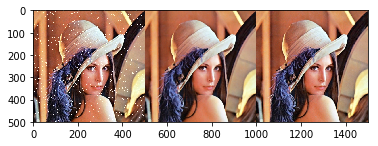

In [3]:
def main():
    # 读取原始图片
    img = cv2.imread('noisy_lenna.jpg')
    # print(img)

    # 使用自己手写的medianBlur进行中值滤波啊
    myself = medianBlur(img, 5, padding_way='ZERO')
    if myself is None:
        return

    # 调用OpenCV的接口进行中值滤波
    opencv = cv2.medianBlur(img, 3)

    # 这里进行图片合并
    img = np.hstack((img, myself))
    img = np.hstack((img, opencv))

    # 显示对比效果
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     cv2.imshow('ORG + myself + OpenCV', img)
#     cv2.waitKey()
#     cv2.destroyAllWindows()


if __name__ == '__main__':
    main()

## 2.RANSAC伪代码

    input:
        data - a set of observations 一组观测数据
        model - a model that can be fitted to data 适用于数据的模型
        n - the minimum number of data required to fit the model 适用于模型的最少数据个数
        k - the number of iterations performed by the algorithm 算法的迭代次数
        t - a threshold value for determining when a datum fits a model 决定数据是否适用于模型的阈值
        d - the number of close data values required to assert that a model fits well to data 决定模型是否适用于数据集的数据数目

    output:
        best_model - model parameters which best fit the data (or null if no good model is found)和数据最匹配的模型参数（如果没有找到好的模型，返回null）
        best_consensus_set - data point from which this model has been estimated 估计出模型的数据点
        best_error - the error of this model relative to the data 与数据相关的模型误差

    iterations = 0

    best_model = null

    best_consensus_set = null

    best_error = infinity

    while iterations < k
        maybe_inliers = n randomly selected values from data  从数据集中随机选择n个内点
        maybe_model = model parameters fitted to maybe_inliers 适合这n个内点的模型参数
        consensus_set = maybe_inliers

        for every point in data not in maybe_inliers  对于每一个不在maybe_inliers 中的数据点
           if point fits maybe_model with an error smaller than t 如果该点适合maybe_model，并且误差小于阈值
               add point to consensus_set  就将该点加入到consensus_set中

        if the number of elements in consensus_set is > d 如果consensus_set中的数据点个数大于d，这暗示着已经找到了好的模型，现在测试该模型到底多好
           (this implies that we may have found a good model,now test how good it is)
           better_model = model parameters fitted to all points in consensus_set 适合consensus_set中所有点的模型参数
           this_error = a measure of how well better_model fits these points 衡量适合这些点的better_model有多好
           if this_error < best_error 比最好的误差还小，说明发现了比之前好的模型，保存该模型直到有更好的模型
              (we have found a model which is better than any of the previous ones,keep it until a better one is found)
               best_model = this_model
               best_consensus_set = consensus_set
               best_error = this_error

        increment iterations迭代次数增加

    return best_model, best_consensus_set, best_error